# NBA Player Analysis: Are the type of players changing?

# Imports

In [815]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt

# Model Building
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

# Resources

Data:

https://www.kaggle.com/abhinavp23/nba-stats-player-and-team

Other Projects:

https://randerson112358.medium.com/nba-data-analysis-exploration-9293f311e0e8

https://dribbleanalytics.blog/2019/04/positional-clustering/

http://suruchifialoke.com/2017-06-01-clustering-nba-players/

https://www.kaggle.com/terrycheng/nba-players-clustering-using-pca-and-kmeans

Model Resources:

https://365datascience.com/pca-k-means/

Rule Changes:

https://cdn.nba.net/nba-drupal-prod/nba-rules-changes-history.pdf

Possible Stats Additions:

https://bleacherreport.com/articles/1039116-understanding-the-nba-explaining-advanced-offensive-stats-and-metrics

# Load Data

In [665]:
data = pd.read_csv('../data/NBA_Season_Stats.csv')

In [666]:
data.shape

(27943, 31)

In [667]:
data.sort_values('Year', inplace=True)

# Clean Data

In [668]:
# Removes second index column.
data.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [669]:
# Removes rows with null values.
data.dropna(axis=0, inplace=True)

In [670]:
data.shape

(17363, 30)

In [671]:
# Strips * from names and records each player that was in the Hall of Fame as 1 and 0 otherwise.
players = []
hf = []

for player_name in data['Player']:
    if player_name.endswith('*'):
        players.append(player_name.strip('*'))
        hf.append(1)
    else:
        players.append(player_name)
        hf.append(0)

In [672]:
len(players)

17363

In [673]:
len(hf)

17363

In [674]:
# Replaces column, Player, with stripped names.
# Adds column, HF, to indicate whether or not a player was inducted into the Hall of Fame
data['Player'] = players
data['HF'] = hf

In [675]:
data.head()

,Year,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HF
5919,1980.0,Pete Maravich,SG,32.0,BOS,26.0,4.0,442.0,123.0,249.0,...,10.0,28.0,38.0,29.0,9.0,2.0,37.0,49.0,299.0,1
5917,1980.0,Pete Maravich,SG,32.0,TOT,43.0,4.0,964.0,244.0,543.0,...,17.0,61.0,78.0,83.0,24.0,6.0,82.0,79.0,589.0,1
5974,1980.0,Rick Robey,C,24.0,BOS,82.0,27.0,1918.0,379.0,727.0,...,209.0,321.0,530.0,92.0,53.0,15.0,151.0,244.0,942.0,0
5700,1980.0,Tiny Archibald,PG,31.0,BOS,80.0,80.0,2864.0,383.0,794.0,...,59.0,138.0,197.0,671.0,106.0,10.0,242.0,218.0,1131.0,1
5756,1980.0,Don Chaney,SG,33.0,BOS,60.0,0.0,523.0,67.0,189.0,...,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,0


In [676]:
data.columns

Index(['Year', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'HF'],
      dtype='object')

In [677]:
# Sums up player's season stats if they were traded within a season.
players = data.groupby(['Year', 'Player', 'Pos'])[['G', 'GS', 'MP', 'FG', 'FGA',
       'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA',
       'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']].sum().reset_index()

In [678]:
# Adds the column, HF.
# Don't know if I need this because players can't be voted into the HF until after they retire. 2000-2019 are going to have less.
players['HF'] = data.groupby(['Year', 'Player', 'Pos'])['HF'].max().reset_index()['HF']

In [679]:
players

,Year,Player,Pos,G,GS,MP,FG,FGA,FG%,3P,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,HF
0,1980.0,Chris Ford,SG,73.0,73.0,2115.0,330.0,709.0,0.465,70.0,...,77.0,104.0,181.0,215.0,111.0,27.0,105.0,178.0,816.0,0
1,1980.0,Dave Cowens,C,66.0,55.0,2159.0,422.0,932.0,0.453,1.0,...,126.0,408.0,534.0,206.0,69.0,61.0,108.0,216.0,940.0,1
2,1980.0,Don Chaney,SG,60.0,0.0,523.0,67.0,189.0,0.354,1.0,...,31.0,42.0,73.0,38.0,31.0,11.0,33.0,80.0,167.0,0
3,1980.0,Gerald Henderson,PG,76.0,2.0,1061.0,191.0,382.0,0.500,2.0,...,37.0,46.0,83.0,147.0,45.0,15.0,109.0,96.0,473.0,0
4,1980.0,Jeff Judkins,SF,65.0,0.0,674.0,139.0,276.0,0.504,11.0,...,32.0,34.0,66.0,47.0,29.0,5.0,49.0,91.0,351.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13719,2019.0,Zach Collins,C,77.0,0.0,17.6,2.5,5.2,0.473,0.5,...,1.4,2.8,4.2,0.9,0.3,0.9,1.0,2.3,6.6,0
13720,2019.0,Zach LaVine,SG,63.0,62.0,34.5,8.4,18.0,0.467,1.9,...,0.6,4.0,4.7,4.5,1.0,0.4,3.4,2.2,23.7,0
13721,2019.0,Zaza Pachulia,C,68.0,3.0,12.9,1.3,2.8,0.440,0.0,...,1.5,2.4,3.9,1.3,0.5,0.3,0.8,2.2,3.9,0
13722,2019.0,Zhaire Smith,SG,6.0,2.0,18.5,2.3,5.7,0.412,1.0,...,0.5,1.7,2.2,1.7,0.3,0.3,1.0,1.3,6.7,0


In [680]:
# Recalculates the percentage columns.
players['FG%'] = players['FG']/players['FGA']
players['FT%'] = players['FT']/players['FTA']
players['3P%'] = players['3P']/players['3PA']
players['2P%'] = players['2P']/players['2PA']
players['eFG%'] = (players['FG'] + 0.5*players['3P'])/players['FGA']

In [681]:
# Changes the year column to an integer
players['Year'] = players['Year'].astype(int)

In [682]:
# Transforms categorical column, Pos, into dummy variables.
players_w_dum = pd.get_dummies(players, columns=['Pos'])
players_w_dum['Pos'] = players['Pos']

In [683]:
# Shape of new dataframe.
players_w_dum.shape

(13724, 45)

In [684]:
# Drops players who have 100% accuracy for shooting.
players_w_dum = players_w_dum[players_w_dum['3P%']<1]
players_w_dum = players_w_dum[players_w_dum['2P%']<1]
players_w_dum = players_w_dum[players_w_dum['FT%']<1]
players_w_dum = players_w_dum[players_w_dum['eFG%']<1]

In [685]:
# Drops any leftover null values.
players_w_dum.dropna(axis=0, inplace=True)

In [686]:
players_w_dum

,Year,Player,G,GS,MP,FG,FGA,FG%,3P,3PA,...,Pos_PG-SF,Pos_PG-SG,Pos_SF,Pos_SF-PF,Pos_SF-SG,Pos_SG,Pos_SG-PF,Pos_SG-PG,Pos_SG-SF,Pos
0,1980,Chris Ford,73.0,73.0,2115.0,330.0,709.0,0.465444,70.0,164.0,...,0,0,0,0,0,1,0,0,0,SG
1,1980,Dave Cowens,66.0,55.0,2159.0,422.0,932.0,0.452790,1.0,12.0,...,0,0,0,0,0,0,0,0,0,C
2,1980,Don Chaney,60.0,0.0,523.0,67.0,189.0,0.354497,1.0,6.0,...,0,0,0,0,0,1,0,0,0,SG
3,1980,Gerald Henderson,76.0,2.0,1061.0,191.0,382.0,0.500000,2.0,6.0,...,0,0,0,0,0,0,0,0,0,PG
4,1980,Jeff Judkins,65.0,0.0,674.0,139.0,276.0,0.503623,11.0,27.0,...,0,0,1,0,0,0,0,0,0,SF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13718,2019,Yuta Watanabe,15.0,0.0,11.6,1.0,3.4,0.294118,0.1,1.1,...,0,0,1,0,0,0,0,0,0,SF
13719,2019,Zach Collins,77.0,0.0,17.6,2.5,5.2,0.480769,0.5,1.6,...,0,0,0,0,0,0,0,0,0,C
13720,2019,Zach LaVine,63.0,62.0,34.5,8.4,18.0,0.466667,1.9,5.1,...,0,0,0,0,0,1,0,0,0,SG
13721,2019,Zaza Pachulia,68.0,3.0,12.9,1.3,2.8,0.464286,0.0,0.1,...,0,0,0,0,0,0,0,0,0,C


In [687]:
# Splits data on 1999 where the five second rule was implemented.
# Five second rule makes the game go faster forcing players to make decisions faster.
pre_rule = players_w_dum[players_w_dum['Year']<=1999]
post_rule = players_w_dum[players_w_dum['Year']>1999]

In [688]:
pre_rule.shape

(5441, 45)

In [689]:
post_rule.shape

(7857, 45)

# EDA

In [690]:
players_w_dum.columns

Index(['Year', 'Player', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA',
       '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB',
       'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'HF', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF', 'Pos'],
      dtype='object')

In [691]:
pos_pre = pre_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
pos_post = post_rule[['Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

In [692]:
main_pre = pos_pre[['Pos_C', 'Pos_PF', 'Pos_SF', 'Pos_SG', 'Pos_PG']]
main_post = pos_post[['Pos_C', 'Pos_PF', 'Pos_SF', 'Pos_SG', 'Pos_PG']]

other_pre = pos_pre[['Pos_C-PF', 'Pos_C-SF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG-SF', 
                     'Pos_PG-SG', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]
other_post = pos_post[['Pos_C-PF', 'Pos_C-SF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG-SF', 
                     'Pos_PG-SG', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']]

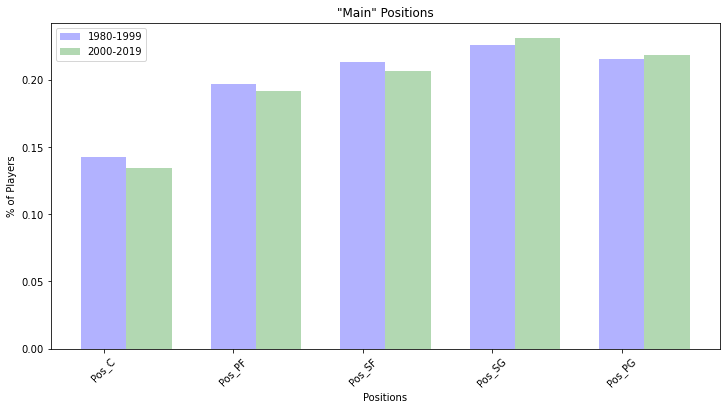

In [693]:
pos = 5
idx = np.arange(pos)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(idx, main_pre.sum()/main_pre.shape[0], width, color='blue', alpha=0.3, label='1980-1999')
ax.bar(idx+width, main_post.sum()/main_post.shape[0], width, color='green', alpha=0.3, label='2000-2019')

ax.set_title('"Main" Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('% of Players')
ax.set_xticks(idx)
ax.set_xticklabels(main_pre.columns, rotation=45)

ax.legend();

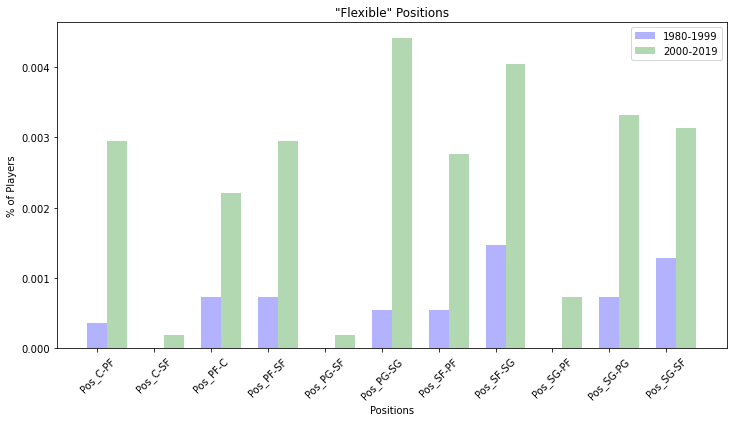

In [694]:
pos = 11
idx = np.arange(pos)
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(idx, other_pre.sum()/other_pre.shape[0], width, color='blue', alpha=0.3, label='1980-1999')
ax.bar(idx+width, other_post.sum()/other_pre.shape[0], width, color='green', alpha=0.3, label='2000-2019')

ax.set_title('"Flexible" Positions')
ax.set_xlabel('Positions')
ax.set_ylabel('% of Players')
ax.set_xticks(idx)
ax.set_xticklabels(other_pre.columns, rotation=45)

ax.legend();

__There are more players overall, which is to be expected since the organization is growing. However, there appears to be more of these 'flexible' players that can play more than one position.__

__C__: Center, 5 (ie. Shaquille O'Neal)

__PF__: Power Foward, 4 (ie. Chris Bosh)

__SF__: Small Foward, 3 (ie. Kawhi Leonard)

__SG__: Shooting Guard, 2 (ie. Klay Thompson)

__PG__: Point Guard, 1 (ie. Stephen Curry)

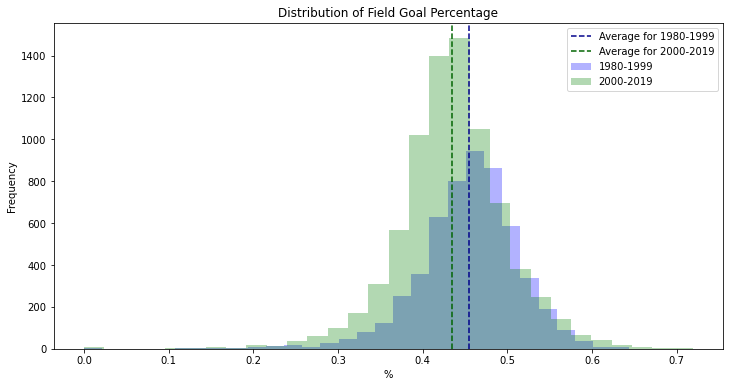

In [695]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(pre_rule['FG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['FG%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['FG%'].mean(), color='darkblue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['FG%'].mean(), color='darkgreen', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

__It appears that the field goal percentage decreased.__

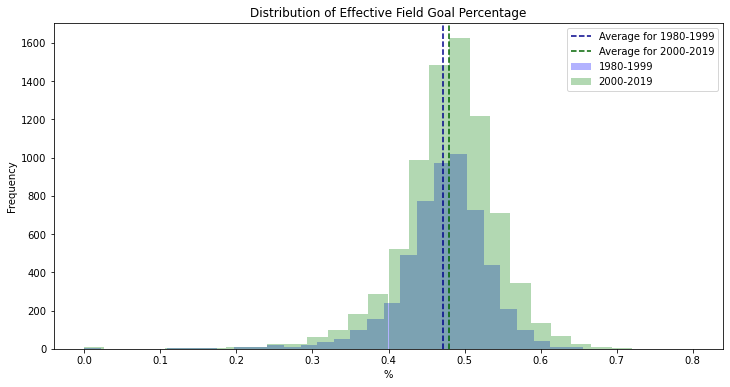

In [696]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(pre_rule['eFG%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['eFG%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['eFG%'].mean(), color='darkblue', linestyle='dashed', label='Average for 1980-1999')
ax.axvline(post_rule['eFG%'].mean(), color='darkgreen', linestyle='dashed', label='Average for 2000-2019')

ax.set_title('Distribution of Effective Field Goal Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

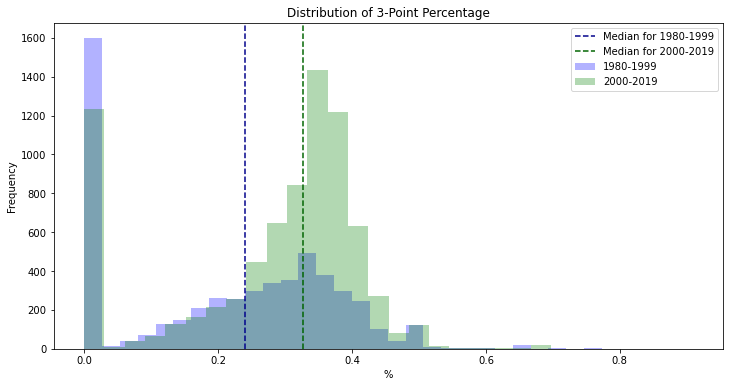

In [803]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.hist(pre_rule['3P%'], bins=30, color='blue', alpha=0.3, label='1980-1999')
ax.hist(post_rule['3P%'], bins=30, color='green', alpha=0.3, label='2000-2019')

ax.axvline(pre_rule['3P%'].median(), color='darkblue', linestyle='dashed', label='Median for 1980-1999')
ax.axvline(post_rule['3P%'].median(), color='darkgreen', linestyle='dashed', label='Median for 2000-2019')

ax.set_title('Distribution of 3-Point Percentage')
ax.set_xlabel('%')
ax.set_ylabel('Frequency')

ax.legend();

__The 3-point line was implemented in 1980, so players from the early 1980's were not used to shooting from that far away. Number of 3-point attempts and 3-point percentages increased.__

# Build Model

## PCA

In [784]:
X_pre = np.array(pre_rule[['G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']])
X_post = np.array(post_rule[['G', 'MP', 'FG%', '3P%', '2P%', 'eFG%', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF']])

In [785]:
X_pre.shape

(5441, 30)

In [786]:
X_post.shape

(7857, 30)

In [787]:
# Scales data.
scaled_pre = StandardScaler().fit_transform(X_pre)
scaled_post = StandardScaler().fit_transform(X_post)

In [788]:
# Initializes and fits PCA's.
pca_pre = PCA().fit(scaled_pre)
pca_post = PCA().fit(scaled_post)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


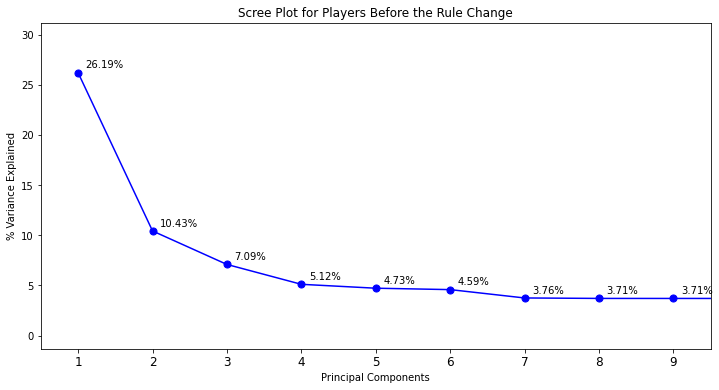

In [793]:
fig, ax = plt.subplots(figsize=(12, 6))

num_components = pca_pre.n_components_
idx = np.arange(num_components)
vals = pca_pre.explained_variance_ratio_*100

ax.plot(idx, vals, color='blue')
ax.scatter(idx, vals, color='blue', s=50)

for i in range(9):
    ax.annotate(r"{:2.2f}%".format(vals[i]), (idx[i]+0.1, vals[i]+0.5))

ax.set_title('Scree Plot for Players Before the Rule Change')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')

ax.set_xticklabels(idx+1, fontsize=12)
ax.set_xticks(np.arange(9))
ax.set_xlim(left=0-0.5, right=8+0.5)
ax.set_ylim(top=max(vals)+5);

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


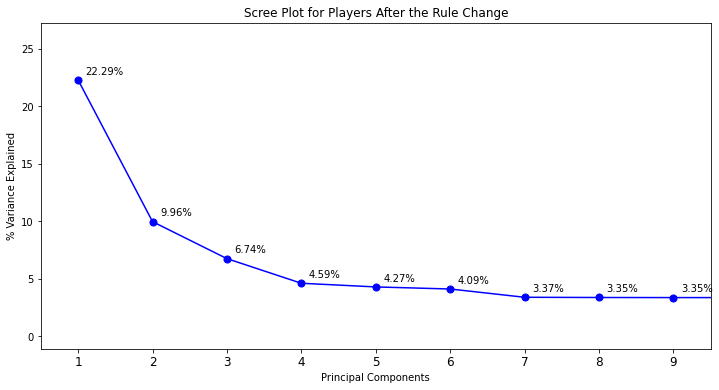

In [794]:
fig, ax = plt.subplots(figsize=(12, 6))

num_components = pca_post.n_components_
idx = np.arange(num_components)
vals = pca_post.explained_variance_ratio_*100

ax.plot(idx, vals, color='blue')
ax.scatter(idx, vals, color='blue', s=50)

for i in range(9):
    ax.annotate(r"{:2.2f}%".format(vals[i]), (idx[i]+0.1, vals[i]+0.5))

ax.set_title('Scree Plot for Players After the Rule Change')
ax.set_xlabel('Principal Components')
ax.set_ylabel('% Variance Explained')

ax.set_xticklabels(idx+1, fontsize=12)
ax.set_xticks(np.arange(9))
ax.set_xlim(left=0-0.5, right=8+0.5)
ax.set_ylim(top=max(vals)+5);

__Most of the variance in players is explained by the first two principal components before the rule was implemented and after.__

In [795]:
# Creates two PCA models with only two the first two principal components.
pre_2_comp = PCA(n_components=2).fit_transform(scaled_pre)
post_2_comp = PCA(n_components=2).fit_transform(scaled_post)

In [904]:
pca_pre.components_[0], pca_pre.components_[1]

(array([ 2.94925895e-01,  3.55499236e-01,  2.42222560e-01,  2.90752399e-02,
         2.29079875e-01,  2.32237267e-01,  9.67814140e-02,  2.99439363e-01,
         2.38924199e-01,  2.91331475e-01,  2.04396007e-01,  3.37130036e-01,
         3.27527388e-01,  3.34403970e-01,  3.55623511e-02, -7.17920994e-03,
         1.01111322e-33,  2.83149327e-02, -1.06318856e-02, -1.67445323e-02,
        -3.68594631e-03, -4.95391164e-35, -1.26352766e-02, -3.71722415e-03,
        -3.52312973e-03, -1.37631461e-02, -4.30701178e-02,  0.00000000e+00,
        -1.83129454e-02, -9.77243787e-03]),
 array([ 5.11617623e-02,  9.29926444e-02, -2.44316436e-01,  3.24258736e-01,
        -1.98131920e-01, -1.32176132e-01,  2.68058240e-01, -2.23031405e-01,
         3.65093903e-01,  2.53198437e-01, -2.98056351e-01,  1.29600085e-01,
        -8.29473572e-02,  8.74270161e-02, -3.15831572e-01, -4.68360398e-03,
        -1.29246971e-26, -2.60416016e-01, -1.56120812e-02, -6.75532588e-03,
         3.60036906e-01,  7.98764037e-28, -5

In [905]:
pca_post.components_[0], pca_post.components_[1]

(array([ 0.24351042,  0.36986176,  0.16535291,  0.02639458,  0.12176044,
         0.13805285,  0.09425562,  0.3324726 ,  0.28448348,  0.3325386 ,
         0.23787745,  0.35234089,  0.34672685,  0.35615949,  0.03352205,
        -0.00538033, -0.00343262,  0.01987978, -0.0059043 , -0.00506297,
         0.00272408,  0.00386121, -0.00545273, -0.00699649, -0.00382528,
        -0.0036593 , -0.03734212,  0.00509507, -0.00392338, -0.00798292]),
 array([-0.01944231, -0.10136579,  0.43471934, -0.23758048,  0.40651725,
         0.32319246, -0.18241074,  0.12800762, -0.26326419, -0.16931678,
         0.23345167, -0.14713406,  0.00314151, -0.09929286,  0.32564569,
         0.02805426,  0.00176876,  0.18061959,  0.00829358,  0.00059788,
        -0.28526896, -0.00977002, -0.02608592, -0.01422401,  0.00122807,
        -0.00840783, -0.13428121, -0.00319687, -0.02129112, -0.01036286]))

In [884]:
# Changed arrays into dataframes and added the position column to color code by.
df_pre = pd.DataFrame(pre_2_comp, columns=['PC1', 'PC2'])
df_pre['Pos'] = np.array(pre_rule['Pos'])

df_post = pd.DataFrame(post_2_comp, columns=['PC1', 'PC2'])
df_post['Pos'] = np.array(post_rule['Pos'])

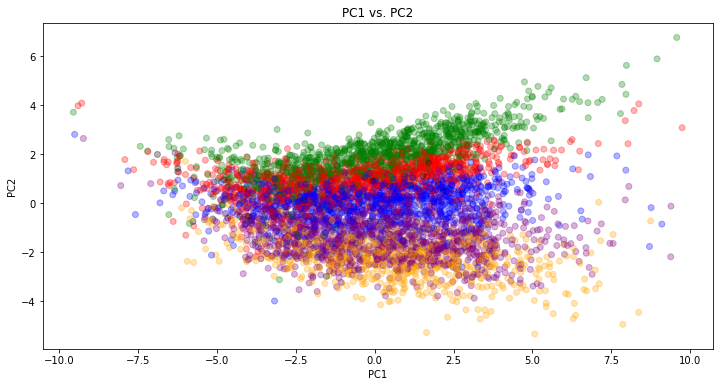

In [885]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {'SG':'red', 'C':'orange', 'PG':'green', 'SF':'blue', 'PF':'purple', 'SG-SF':'black', 'C-PF':'black', 'SF-SG':'black', 'SF-PF':'black',
       'PG-SG':'black', 'PF-C':'black', 'PF-SF':'black', 'SG-PG':'black'}

ax.scatter(df_pre['PC1'], df_pre['PC2'], c=df_pre['Pos'].map(colors), alpha=0.3)

ax.set_title('PC1 vs. PC2')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

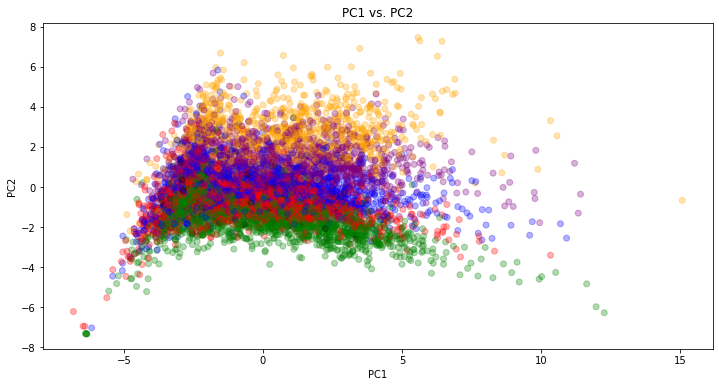

In [886]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {'PF':'purple', 'SG':'red', 'C':'orange', 'PG':'green', 'SF':'blue', 'SF-PF':'black', 'PF-SF':'black', 'SF-SG':'black', 'C-PF':'black',
       'SG-PG':'black', 'PG-SG':'black', 'SG-SF':'black', 'PF-C':'black', 'PG-SF':'black', 'SG-PF':'black', 'C-SF':'black'}

ax.scatter(df_post['PC1'], df_post['PC2'], c=df_post['Pos'].map(colors), alpha=0.3)

ax.set_title('PC1 vs. PC2')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

## KMeans

In [887]:
pre = pre_rule.drop(['Year', 'Player', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF', 'Pos'], axis=1)

In [888]:
post = post_rule.drop(['Year', 'Player', 'Pos_C',
       'Pos_C-PF', 'Pos_C-SF', 'Pos_PF', 'Pos_PF-C', 'Pos_PF-SF', 'Pos_PG',
       'Pos_PG-SF', 'Pos_PG-SG', 'Pos_SF', 'Pos_SF-PF', 'Pos_SF-SG', 'Pos_SG',
       'Pos_SG-PF', 'Pos_SG-PG', 'Pos_SG-SF', 'Pos'], axis=1)

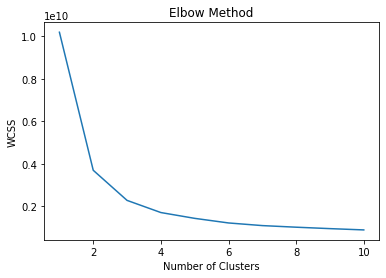

In [889]:
# Find the elbow.
wcss = []
for i in range(1, 11):
    kmeans_pre = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(pre)
    wcss.append(kmeans_pre.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

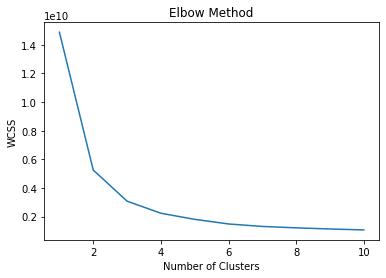

In [890]:
wcss = []
for i in range(1, 11):
    kmeans_post = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0).fit(post)
    wcss.append(kmeans_post.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [891]:
# Initializes and fits KMeans model using PCA dimension reduced models.
kmeans_pre = KMeans(n_clusters=2, random_state=11).fit(pre_2_comp)
kmeans_post = KMeans(n_clusters=2, random_state=11).fit(post_2_comp)

In [892]:
# Adds cluster assignment column to original dataset.
cluster_labels = kmeans_pre.labels_
df_pre['Cluster'] = cluster_labels

cluster_labels = kmeans_post.labels_
df_post['Cluster'] = cluster_labels

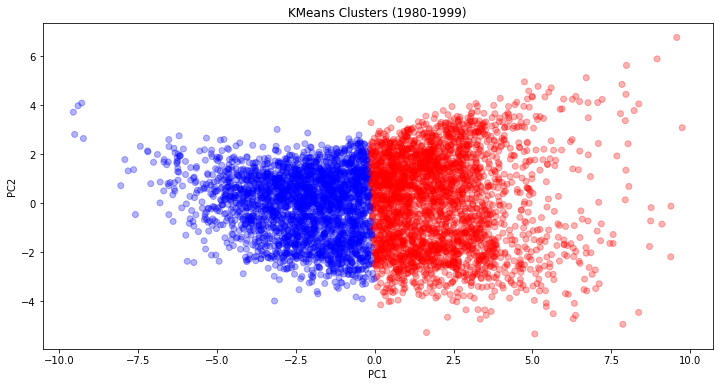

In [893]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {0:'red', 1:'blue'}

ax.scatter(df_pre['PC1'], df_pre['PC2'], c=df_pre['Cluster'].map(colors), alpha=0.3)

ax.set_title('KMeans Clusters (1980-1999)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

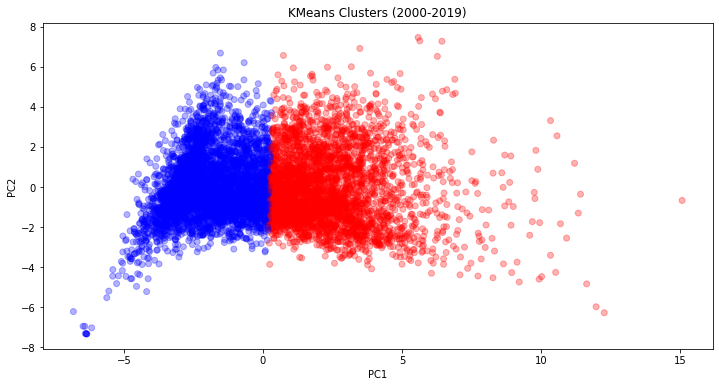

In [894]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {0:'red', 1:'blue'}

ax.scatter(df_post['PC1'], df_post['PC2'], c=df_post['Cluster'].map(colors), alpha=0.3)

ax.set_title('KMeans Clusters (2000-2019)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

__KMeans is not a good clustering method.__

## Hierachial Clustering

In [895]:
silhouette_coefs = []
for k in range(2, 11):
    ha = AgglomerativeClustering(n_clusters=k, linkage='average').fit(pre_2_comp)
    score = silhouette_score(pre_2_comp, ha.labels_)
    silhouette_coefs.append(score)

In [896]:
silhouette_coefs = []
for k in range(2, 11):
    ha = AgglomerativeClustering(n_clusters=k, linkage='average').fit(post_2_comp)
    score = silhouette_score(post_2_comp, ha.labels_)
    silhouette_coefs.append(score)

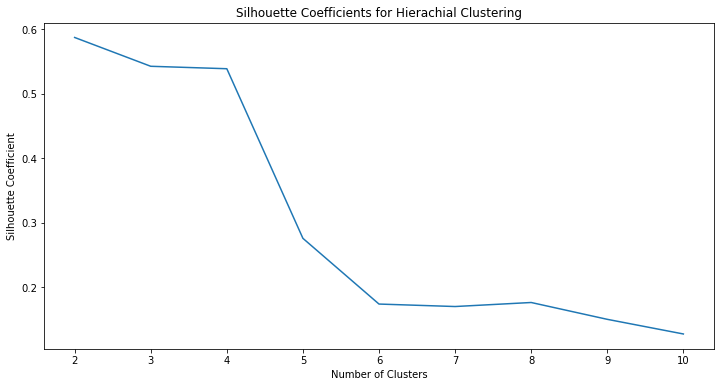

In [898]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(2, 11), silhouette_coefs)

ax.set_title('Silhouette Coefficients for Hierachial Clustering')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Coefficient');

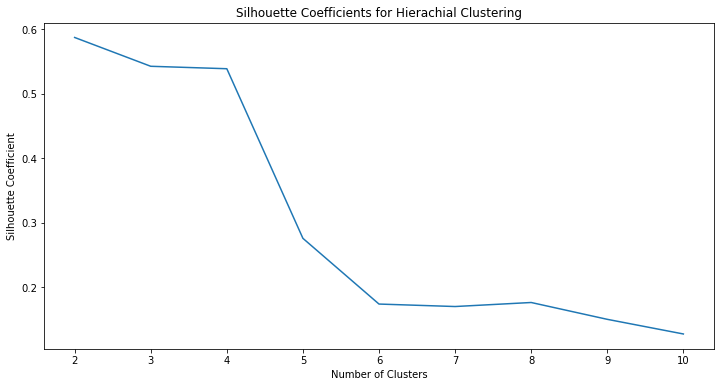

In [899]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(range(2, 11), silhouette_coefs)

ax.set_title('Silhouette Coefficients for Hierachial Clustering')
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Coefficient');

In [900]:
# Initializes and fits using the Hiearachial Clustering model.
ha_pre = AgglomerativeClustering(n_clusters=2, linkage='average').fit(pre_2_comp)
ha_post = AgglomerativeClustering(n_clusters=2, linkage='average').fit(post_2_comp)

In [901]:
cluster_labels = ha_pre.labels_
df_pre['Cluster'] = cluster_labels

cluster_labels = ha_post.labels_
df_post['Cluster'] = cluster_labels

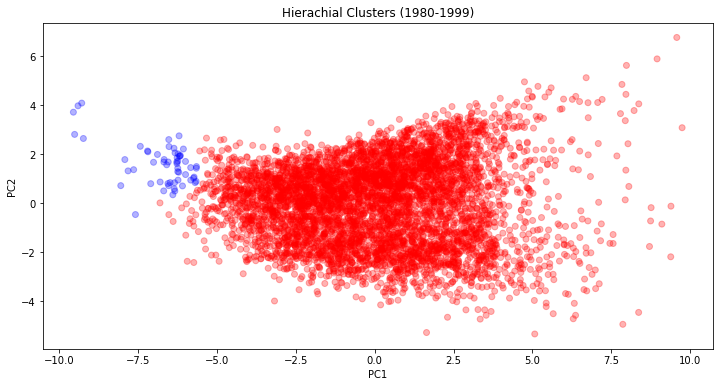

In [902]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {0:'red', 1:'blue'}

ax.scatter(df_pre['PC1'], df_pre['PC2'], c=df_pre['Cluster'].map(colors), alpha=0.3)

ax.set_title('Hierachial Clusters (1980-1999)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');

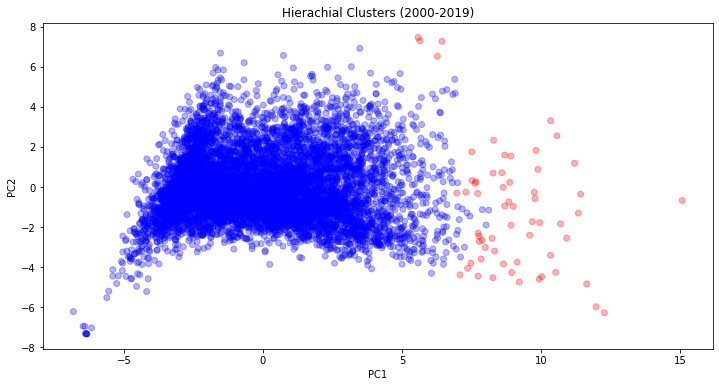

In [903]:
fig, ax = plt.subplots(figsize=(12, 6))

colors = {0:'red', 1:'blue'}

ax.scatter(df_post['PC1'], df_post['PC2'], c=df_post['Cluster'].map(colors), alpha=0.3)

ax.set_title('Hierachial Clusters (2000-2019)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2');